In [6]:
import pandas as pd
from datetime import timedelta

# ===============================
# Load and Prepare Datasets
# ===============================
df_events = pd.read_csv('Fire_Events_Data_Cleaned.csv')
df_calls = pd.read_csv('iotdata_activations.csv')




C:\Users\User\AppData\Local\Temp\ipykernel_20304\3675597792.py:7: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_events = pd.read_csv('Fire_Events_Data_Cleaned.csv')


In [7]:
# --- Clean and convert ADDEDAT (events) ---
df_events['ADDEDAT'] = pd.to_datetime(df_events['ADDEDAT'], errors='coerce')
df_events = df_events.dropna(subset=['ADDEDAT'])
df_events['ADDEDAT'] = df_events['ADDEDAT'].dt.tz_localize('UTC').dt.tz_convert('Australia/Sydney')

# --- Convert Excel-style activation timestamps ---
df_calls['alarm_date_time'] = pd.to_numeric(df_calls['alarm_date_time'], errors='coerce')
df_calls = df_calls.dropna(subset=['alarm_date_time'])
df_calls['ALARM_DATETIME'] = pd.to_timedelta(df_calls['alarm_date_time'], unit='D') + pd.Timestamp('1899-12-30')
df_calls['ALARM_DATETIME'] = df_calls['ALARM_DATETIME'].dt.tz_localize('Australia/Sydney')

# ===============================
# Standardize Site Name Fields
# ===============================
df_events.rename(columns={'SITEID': 'Site Name'}, inplace=True)
df_events['Site Name'] = df_events['Site Name'].astype(str).str.strip().str.lower()
df_calls['Site Name'] = df_calls['Site Name'].astype(str).str.strip().str.lower()

In [19]:

# ===============================
# Filter Last 14 Days of Events
# ===============================
latest_time = pd.Timestamp("2025-03-11 00:00:00", tz='Australia/Sydney')
cutoff_time = latest_time - timedelta(days=30)
recent_events = df_events[df_events['ADDEDAT'] >= cutoff_time].copy()

# ===============================
# Step 1: Fault = on in Last 14 Days
# ===============================
fault_events = recent_events[recent_events['fault'].str.lower() == 'on'].copy()

In [20]:
# ===============================
# Step 2: Check if any Alarm = on occurred ±5 minutes of the fault
# ===============================
def had_alarm_nearby(row):
    site = row['Site Name']
    event_time = row['ADDEDAT']
    window_start = event_time - timedelta(minutes=5)
    window_end = event_time + timedelta(minutes=5)

    match = recent_events[
        (recent_events['Site Name'] == site) &
        (recent_events['alarm'].str.lower() == 'on') &
        (recent_events['ADDEDAT'] >= window_start) &
        (recent_events['ADDEDAT'] <= window_end)
    ]
    return int(not match.empty)

fault_events['alarm_nearby'] = fault_events.apply(had_alarm_nearby, axis=1)
fault_with_alarm = fault_events[fault_events['alarm_nearby'] == 1].copy()


In [21]:
# ===============================
# Step 3: Check for Brigade Callouts (±5 min from fault time)
# ===============================
def was_brigade_called(row):
    site = row['Site Name']
    event_time = row['ADDEDAT']
    window_start = event_time - timedelta(minutes=5)
    window_end = event_time + timedelta(minutes=5)

    match = df_calls[
        (df_calls['Site Name'] == site) &
        (df_calls['ALARM_DATETIME'] >= window_start) &
        (df_calls['ALARM_DATETIME'] <= window_end)
    ]
    return int(not match.empty)

if not fault_with_alarm.empty:
    fault_with_alarm['brigade_callout'] = fault_with_alarm.apply(was_brigade_called, axis=1)
    escalated = fault_with_alarm['brigade_callout'].sum()
else:
    escalated = 0

In [22]:

# Output Summary
# ===============================
print("\n--- Summary (Last 14 Days) ---")
print(f"Total Fault Events: {len(fault_events)}")
print(f"Faults that triggered Alarms (within ±5min): {len(fault_with_alarm)}")
print(f"Alarms escalated to Brigade Callouts: {escalated}")

if len(fault_events) > 0:
    print(f"% Faults → Alarms: {len(fault_with_alarm) / len(fault_events):.2%}")
if len(fault_with_alarm) > 0:
    print(f"% Alarms → Brigade Callouts: {escalated / len(fault_with_alarm):.2%}")


--- Summary (Last 14 Days) ---
Total Fault Events: 7441
Faults that triggered Alarms (within ±5min): 346
Alarms escalated to Brigade Callouts: 21
% Faults → Alarms: 4.65%
% Alarms → Brigade Callouts: 6.07%


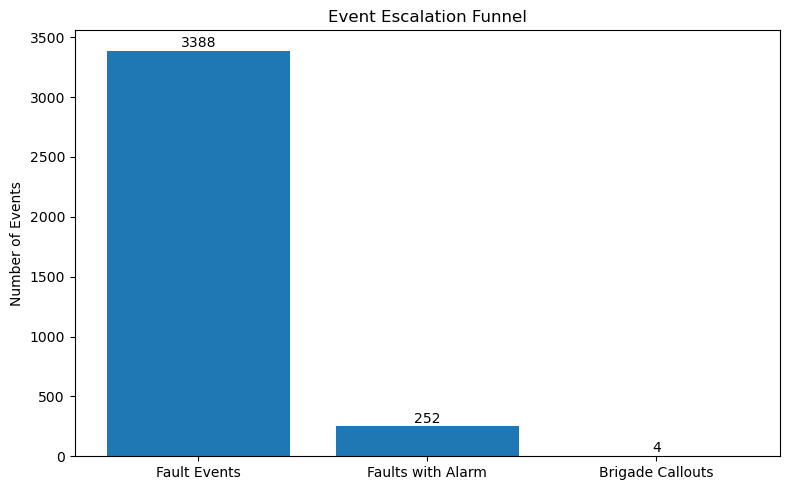

In [17]:
import matplotlib.pyplot as plt

# Simple conversion funnel counts
stage_labels = ['Fault Events', 'Faults with Alarm', 'Brigade Callouts']
stage_counts = [len(fault_events), len(fault_with_alarm), fault_with_alarm['brigade_callout'].sum()]

plt.figure(figsize=(8, 5))
plt.bar(stage_labels, stage_counts)
plt.title("Event Escalation Funnel")
plt.ylabel("Number of Events")
for i, count in enumerate(stage_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()
